# Understanding Bayesian Marketing Mix Modeling: A Deep Dive into Prior Specifications
## Exploring Model Specification with Google's LightweightMMM

Slava Kisilevich
kisilevich.slava@gmail.com

In [2]:
import pandas as pd
import numpy as np
from lightweight_mmm import preprocessing

from scipy import stats

from sklearn import preprocessing as scikit_preprocessing
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpyro
numpyro.set_host_device_count(8)


pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
#suppress exponential notation, define an appropriate float formatter
#specify stdout line width and let pretty print do the work
np.set_printoptions(suppress=True, formatter={'float_kind':'{:16.3f}'.format}, linewidth=130)


import warnings
warnings.filterwarnings("ignore")

/home/slaks/anaconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
class AdstockGeometric(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=0.5):
        self.alpha = alpha
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X: np.ndarray):
        x_decayed = np.zeros_like(X)
        x_decayed[0] = X[0]
        
        for xi in range(1, len(x_decayed)):
            x_decayed[xi] = X[xi] + self.alpha * x_decayed[xi - 1]
        return x_decayed
    
class HillSaturation(BaseEstimator, TransformerMixin):
    def __init__(self, slope_s, half_saturation_k):
        self.slope_s = slope_s
        self.half_saturation_k = half_saturation_k
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X: np.ndarray, x_point = None):
        
        self.half_saturation_k_transformed  = self.half_saturation_k * (np.max(X) - np.min(X)) + np.min(X)
        
        if x_point is None:
            return (1 + self.half_saturation_k_transformed**self.slope_s / X**self.slope_s)**-1
        
        #calculate y at x_point
        return (1 + self.half_saturation_k_transformed**self.slope_s / x_point**self.slope_s)**-1
        

def draw_beta_distribution(alpha, beta, title=None, figsize=(20, 6)):
    beta_dist = stats.beta(a=alpha, b = beta)
    samples = beta_dist.rvs(size=1000)

    plt.figure(figsize=figsize)
    sns.histplot(samples, bins=50, kde=False, stat='density', alpha=0.5)
    sns.lineplot(x=np.linspace(0, 1, 100), y=beta_dist.pdf(np.linspace(0, 1, 100)), color='r')

    if title is None:
        title = f"Beta Distribution with alpha={alpha} and beta={beta}"
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('P(X=x)')

    # Show the plot
    plt.show()

## Data

In [4]:
data = pd.read_csv("./data/data_raw_2015-11-23__2019-11-11.csv", parse_dates = ["DATE"])
data.columns = [c.lower() if c in ["DATE"] else c for c in data.columns]
print(data.shape)


holidays = pd.read_csv("./data/prophet_holidays_daily.csv", parse_dates = ["ds"])
holidays["begin_week"] = holidays["ds"].dt.to_period('W-SUN').dt.start_time
#combine same week holidays into one holiday
holidays_weekly = holidays.groupby(["begin_week", "country"], as_index = False).agg({'holiday':'#'.join, 'country': 'first'}).rename(columns = {'begin_week': 'ds'})
holidays_weekly_de = holidays_weekly.query("(country == 'DE')").copy()
holidays_weekly_de

data = pd.merge(data, holidays_weekly_de[["ds", "holiday"]], how="left", left_on="date", right_on="ds")
data.shape

data["holiday"] = data["holiday"].fillna("no-holiday")
del data["ds"]
#0 or 1 holidays
data["holidays_binary"] = np.where(data["holiday"] == "no-holiday", 0, 1)
#0,1,2
data["events_binary"] = data["events"].factorize()[0]

(208, 12)


### Variables

In [5]:
media_channels = ["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P"] 
impression_dict = {"facebook_I": "facebook_S", "search_clicks_P": "search_S"}

organic_channels = ["newsletter"]

factorized_variables = ["holidays_binary", "events_binary"]
continuous_variables = ["competitor_sales_B"] + organic_channels
control_variable = factorized_variables + continuous_variables 


target = "revenue"

### Total Spend

In [6]:
costs_train_sum = []
costs_train_mean = []

costs_train_mean_including_zero = []

exposure_train_mean = []
exposure_train_mean_including_zero = []

for media_channel in media_channels:
    print(media_channel)
    cost_channel = impression_dict.get(media_channel)
    if cost_channel is None:
        cost_channel = media_channel
    
    cost_sum = data[cost_channel].sum(axis=0)
    cost_mean_inc_zero = data[cost_channel].mean(axis = 0)
    
    
    costs_train_sum.append(cost_sum)
    costs_train_mean_including_zero.append(cost_mean_inc_zero)
    
    
    
    
    
    exposure_mean_inc_zero = data[media_channel].mean(axis = 0)
    exposure_train_mean_including_zero.append(exposure_mean_inc_zero)
    
spend_df = pd.DataFrame({'media': media_channels, 
                         'total_spend': costs_train_sum, 
                         "average_spend_including_zeros": costs_train_mean_including_zero,
                         "average_exposure_including_zeros": exposure_train_mean_including_zero})
spend_df["spend_share"] = spend_df["total_spend"] / spend_df["total_spend"].sum()
spend_df

tv_S
ooh_S
print_S
facebook_I
search_clicks_P


,media,total_spend,average_spend_including_zeros,average_exposure_including_zeros,spend_share
0,tv_S,23156158.30000,111327.68413,111327.68413,0.33832
1,ooh_S,16854997.00000,81033.63942,81033.63942,0.24626
2,print_S,5816666.33333,27964.74199,27964.74199,0.08498
3,facebook_I,13388904.83608,64369.73479,24460244.99413,0.19562
4,search_clicks_P,9228200.00000,44366.34615,50835.62054,0.13483


### Scaling the data

In [7]:
media_names = media_channels


costs = spend_df["total_spend"]

media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

factorized_scaler = preprocessing.CustomScaler(divide_operation=jnp.max)
continuous_scaler = preprocessing.CustomScaler(divide_operation=jnp.max)

target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

media_data_scaled = media_scaler.fit_transform(data[media_channels].values)
factorized_data_scaled = factorized_scaler.fit_transform(data[factorized_variables].values)
continuous_data_scaled = continuous_scaler.fit_transform(data[continuous_variables].values)
target_scaled = target_scaler.fit_transform(data[target].values.squeeze())
costs_scaled = cost_scaler.fit_transform(costs.values)

print(f"media scaled: {media_data_scaled.shape}")
print(f"factorized control scaled: {factorized_data_scaled.shape}")
print(f"continuous scaled: {continuous_data_scaled.shape}")
print(f"target scaled: {target_scaled.shape}")
print(f"costs scaled: {costs_scaled.shape}")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


media scaled: (208, 5)
factorized control scaled: (208, 2)
continuous scaled: (208, 2)
target scaled: (208,)
costs scaled: (5,)


In [8]:
components = pd.DataFrame()
components["date"] = data["date"]
components["t_scaled"] = scikit_preprocessing.MinMaxScaler().fit_transform(np.array(range(0, len(data["date"]))).astype(float).reshape(-1, 1)).reshape(-1)
components["revenue"] = data["revenue"]
components["revenue_scaled"] = target_scaled

## Components

$ response_t = \alpha + trend_t + seasonality_t + media\_channels_t + other\_factors_t $

### Intercept

$$ \alpha \sim HalfNormal(2) $$

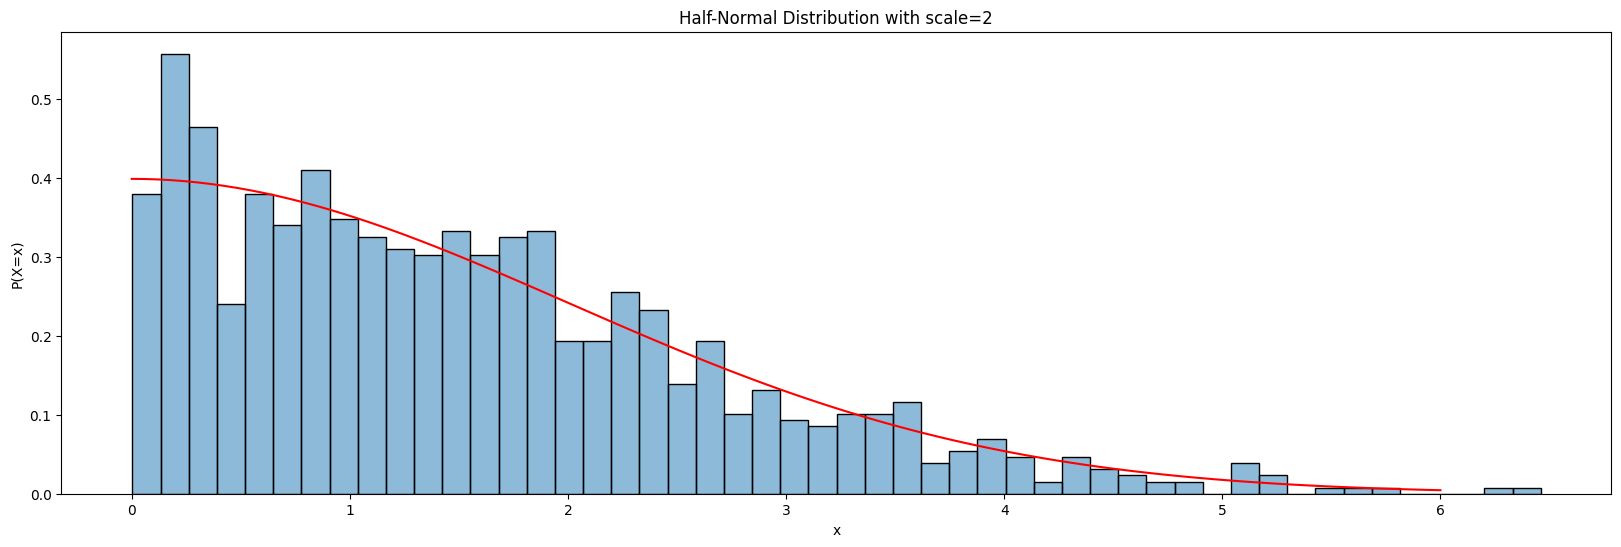

In [9]:
scale = 2
halfnormal_dist = stats.halfnorm(scale=scale)
samples = halfnormal_dist.rvs(size=1000)

plt.figure(figsize=(20, 6))
sns.histplot(samples, bins=50, kde=False, stat='density', alpha=0.5)
sns.lineplot(x=np.linspace(0, 6, 100), y=halfnormal_dist.pdf(np.linspace(0, 6, 100)), color='r')

plt.title(f"Half-Normal Distribution with scale={scale}")
plt.xlabel('x')
plt.ylabel('P(X=x)')
plt.show()

In [10]:
components["intercept"] = stats.halfnorm(scale=scale).rvs()
components.head()

,date,t_scaled,revenue,revenue_scaled,intercept
0,2015-11-23,0.00000,2754371.66667,1.51161,0.51284
1,2015-11-30,0.00483,2584276.66667,1.41826,0.51284
2,2015-12-07,0.00966,2547386.66667,1.39802,0.51284
3,2015-12-14,0.01449,2875220.00000,1.57793,0.51284
4,2015-12-21,0.01932,2215953.33333,1.21612,0.51284


### Trend

$$trend_t = \mu * t^k$$
$$\mu \sim Normal(0, 1)$$
$$k \sim Uniform(0.5, 1.5)$$
where $t$ is a linear trend input

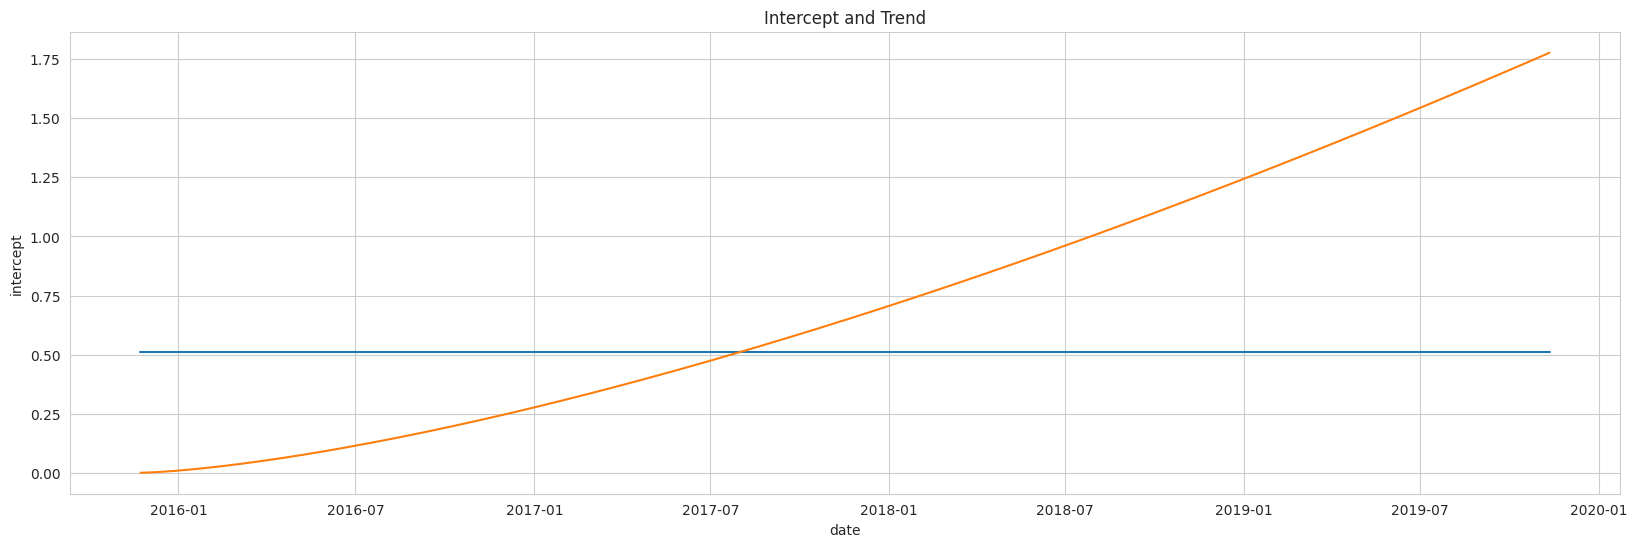

In [11]:
mu = np.random.normal(loc = 0, scale = 1, size=1)
k = np.random.uniform(low = 0.5, high = 1.5)
trend = mu * components["t_scaled"] ** k
components["trend"] = trend
sns.set_style('whitegrid')
plt.figure(figsize=(20, 6))
sns.lineplot(x='date', y='intercept', data=components)
sns.lineplot(x='date', y='trend', data=components)
plt.title('Intercept and Trend')
plt.show()

### Seasonality

$$ seasonality_t = \sum_{d=1}^{2}(\gamma_{1,d}*cos(\frac{2 \pi d t}{52}) + \gamma_{2,d}*sin(\frac{2 \pi d t}{52}))$$
$$ \gamma_{1,d}, \gamma_{2,d} \sim Normal(0, 1)$$

In [12]:
np.random.seed(6)
def fourier_series(t, period=52, n_components=2):
    x = 2 * np.pi * np.arange(1, n_components + 1) / period
    x = x * t[:, None]
    x = np.concatenate((np.cos(x), np.sin(x)), axis=1)
    return x

def generate_seasonality(t, gammas, period=52, n_components=2):
    fourier_ = fourier_series(np.array(range(len(t))), period=period, n_components=n_components) 
    seasonality = fourier_ @ gammas
    return seasonality

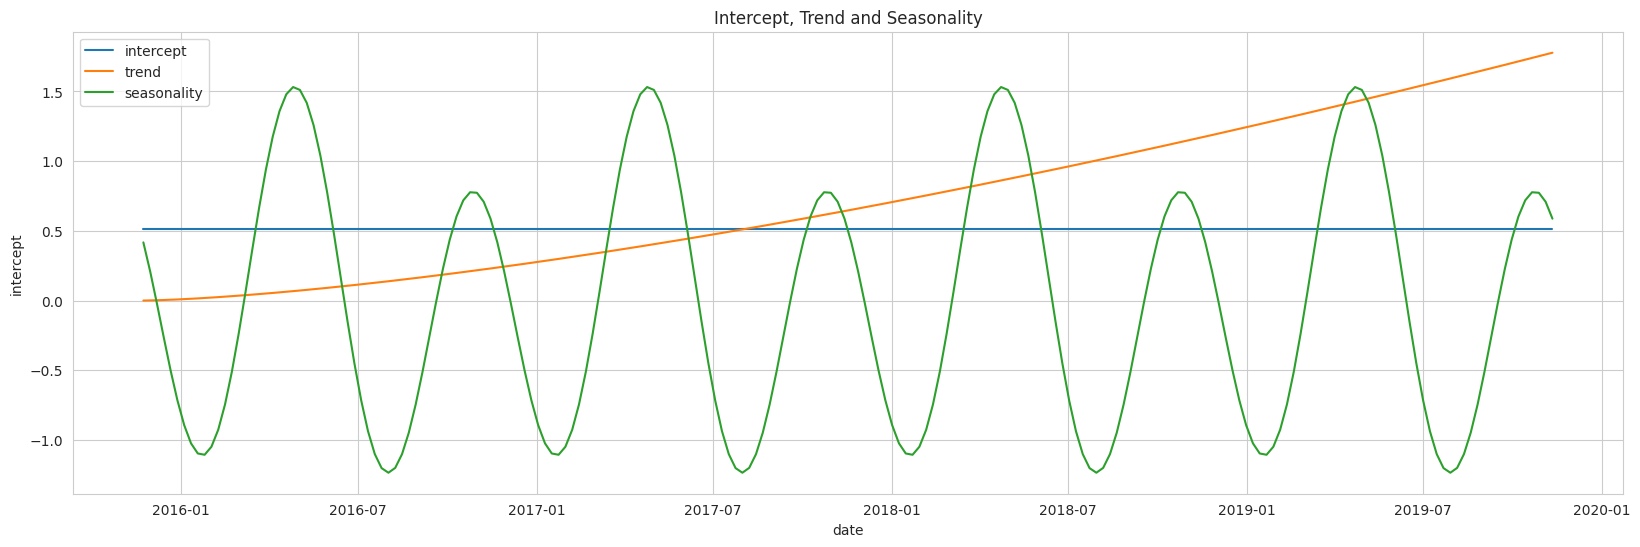

In [13]:
n_components = 2

gammas = np.random.normal(loc = 0, scale = 1, size=n_components*2)
seasonality = generate_seasonality(components["date"], period=52, n_components=2, gammas = gammas)
components["seasonality"] = seasonality
sns.set_style('whitegrid')
plt.figure(figsize=(20, 6))
sns.lineplot(x='date', y='intercept', data=components, label="intercept")
sns.lineplot(x='date', y='trend', data=components, label="trend")
sns.lineplot(x='date', y='seasonality', data=components, label="seasonality")
plt.title('Intercept, Trend and Seasonality')
plt.legend()
plt.show()

### Other factors: control variables

$$ Other\;factors_t = \sum_{i=1}^{N} \lambda_i Z_{it}$$
$$ \lambda_i \sim Normal(0, 1) $$

#### Continuous variables

In [14]:
continuous_variables

['competitor_sales_B', 'newsletter']

In [15]:
other_factors_continuous_lambdas = np.random.normal(loc = 0, scale = 1, size=continuous_data_scaled.shape[1])
other_factors_continuous_lambdas

array([          -2.487,            0.913])

In [16]:
continuous_data_scaled.max(axis=0)

Array([           1.000,            1.000], dtype=float32)

In [17]:
other_factors_continuous = continuous_data_scaled @ other_factors_continuous_lambdas
components["other_factors_continuous"] = np.asarray(other_factors_continuous)

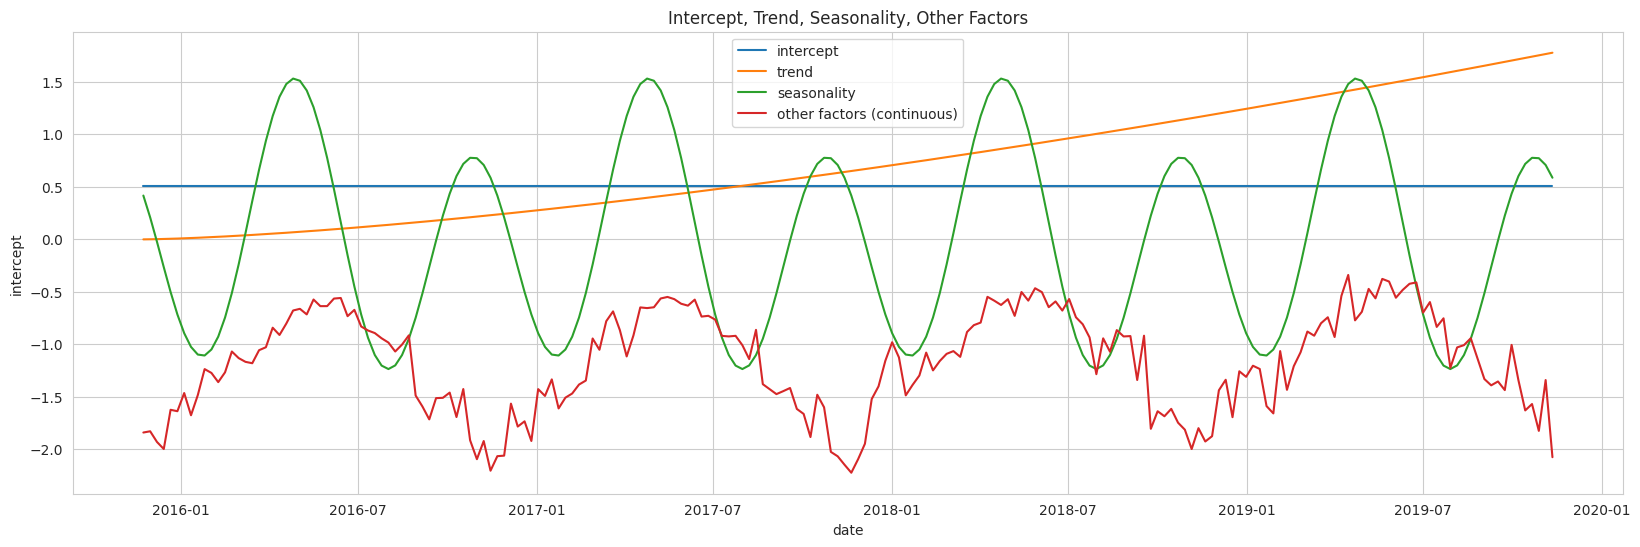

In [18]:
sns.set_style('whitegrid')
plt.figure(figsize=(20, 6))
sns.lineplot(x='date', y='intercept', data=components, label="intercept")
sns.lineplot(x='date', y='trend', data=components, label="trend")
sns.lineplot(x='date', y='seasonality', data=components, label="seasonality")
sns.lineplot(x='date', y='other_factors_continuous', data=components, label="other factors (continuous)")
plt.title('Intercept, Trend, Seasonality, Other Factors')
plt.legend()
plt.show()

#### Factorized variables

In [19]:
factorized_variables

['holidays_binary', 'events_binary']

In [20]:
other_factors_factorized_lambdas = np.random.normal(loc = 0, scale = 1, size=factorized_data_scaled.shape[1])
other_factors_factorized_lambdas

array([           1.127,           -1.514])

In [21]:
factorized_data_scaled.max(axis=0)

Array([           1.000,            1.000], dtype=float32)

In [22]:
other_factors_factorized = factorized_data_scaled @ other_factors_factorized_lambdas
components["other_factors_factorized"] = np.asarray(other_factors_factorized)

In [23]:
components["other_factors"] = components["other_factors_continuous"] + components["other_factors_factorized"]

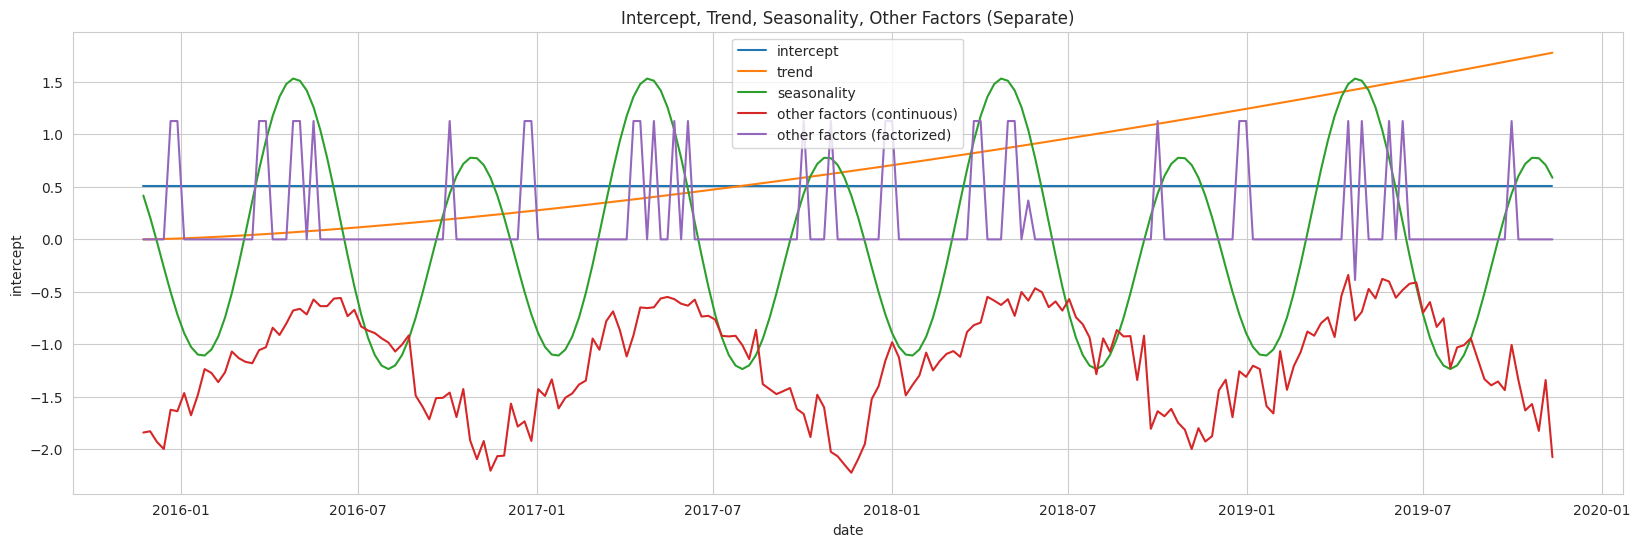

In [24]:
sns.set_style('whitegrid')
plt.figure(figsize=(20, 6))
sns.lineplot(x='date', y='intercept', data=components, label="intercept")
sns.lineplot(x='date', y='trend', data=components, label="trend")
sns.lineplot(x='date', y='seasonality', data=components, label="seasonality")
sns.lineplot(x='date', y='other_factors_continuous', data=components, label="other factors (continuous)")
sns.lineplot(x='date', y='other_factors_factorized', data=components, label="other factors (factorized)")
plt.title('Intercept, Trend, Seasonality, Other Factors (Separate)')
plt.legend()
plt.show()

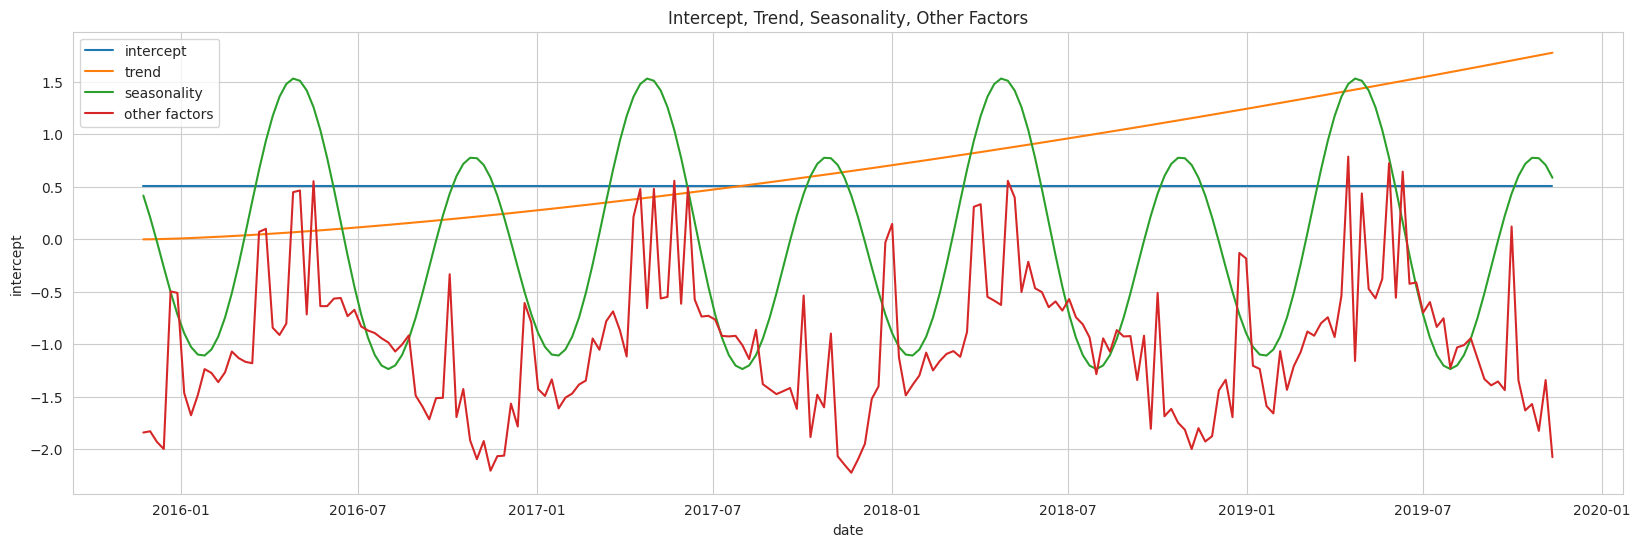

In [25]:
sns.set_style('whitegrid')
plt.figure(figsize=(20, 6))
sns.lineplot(x='date', y='intercept', data=components, label="intercept")
sns.lineplot(x='date', y='trend', data=components, label="trend")
sns.lineplot(x='date', y='seasonality', data=components, label="seasonality")
sns.lineplot(x='date', y='other_factors', data=components, label="other factors")
plt.title('Intercept, Trend, Seasonality, Other Factors')
plt.legend()
plt.show()

## Media Effects

$$ \beta_m \sim HalfNormal(v_m) $$

Where $v_m$ is a scalar equal to the sum of the total cost of media channel $m$

In [26]:
spend_df["total_spend"]

0   23156158.30000
1   16854997.00000
2    5816666.33333
3   13388904.83608
4    9228200.00000
Name: total_spend, dtype: float64

In [27]:
costs_scaled

Array([           1.692,            1.231,            0.425,            0.978,            0.674], dtype=float32)

In [28]:
media_coefficients = stats.halfnorm(scale=costs_scaled).rvs()
media_coefficients

array([           2.773,            0.529,            1.118,            0.589,            0.226])

## Media Channels (for the hill_adstock model)

$$ media \; channels_t = \frac{1}{1 + (x_{t,m}^*/K_m)^{-S_m}} $$
$$ x_{t,m}^* = x_{t,m} + \lambda x_{t-1,m}^* \quad where \; t = 2,.., N $$
$$ x_{1,m}^* = x_{1,m} $$
$$ K_m \sim Gamma(1,1) $$
$$ S_m \sim Gamma(1,1) $$
$$ \lambda_m \sim Beta(2, 1) $$ 

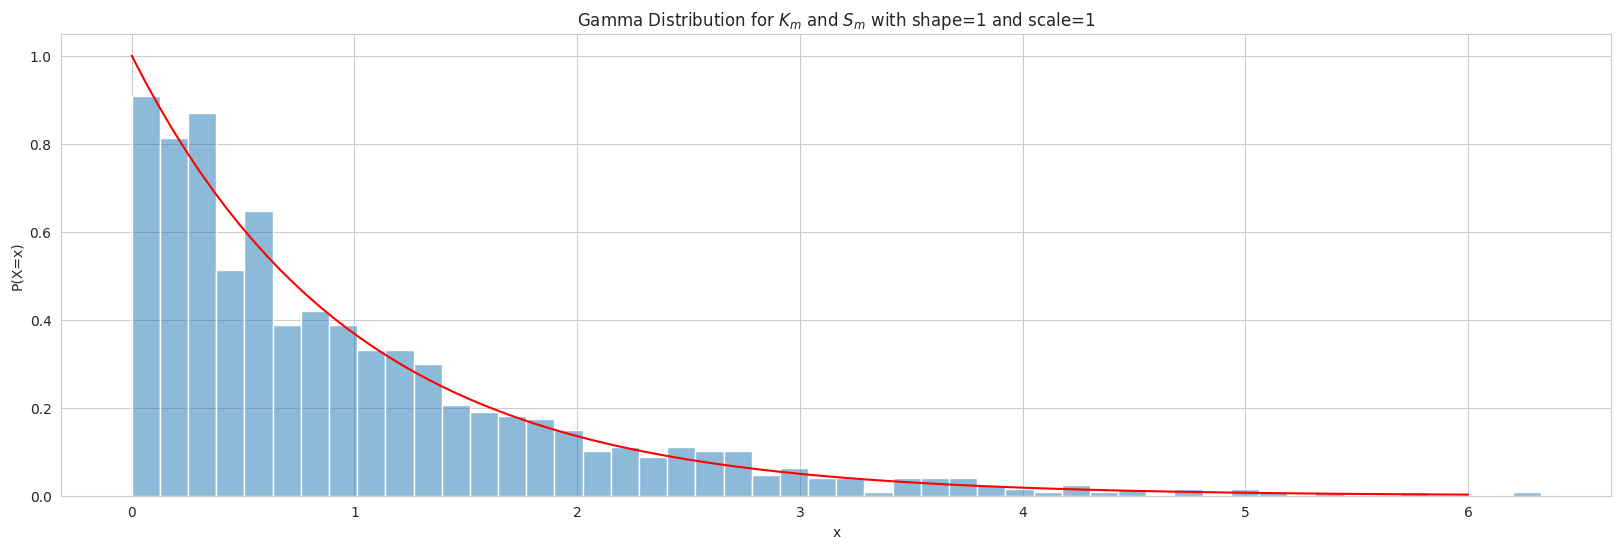

In [29]:
shape = 1
scale = 1

gamma_dist = stats.gamma(a=shape, scale=scale)
samples = gamma_dist.rvs(size=1000)

plt.figure(figsize=(20, 6))
sns.histplot(samples, bins=50, kde=False, stat='density', alpha=0.5)
sns.lineplot(x=np.linspace(0, 6, 100), y=gamma_dist.pdf(np.linspace(0, 6, 100)), color='r')

plt.title(f"Gamma Distribution for $K_m$ and $S_m$ with shape={shape} and scale={scale}")
plt.xlabel('x')
plt.ylabel('P(X=x)')

# Show the plot
plt.show()

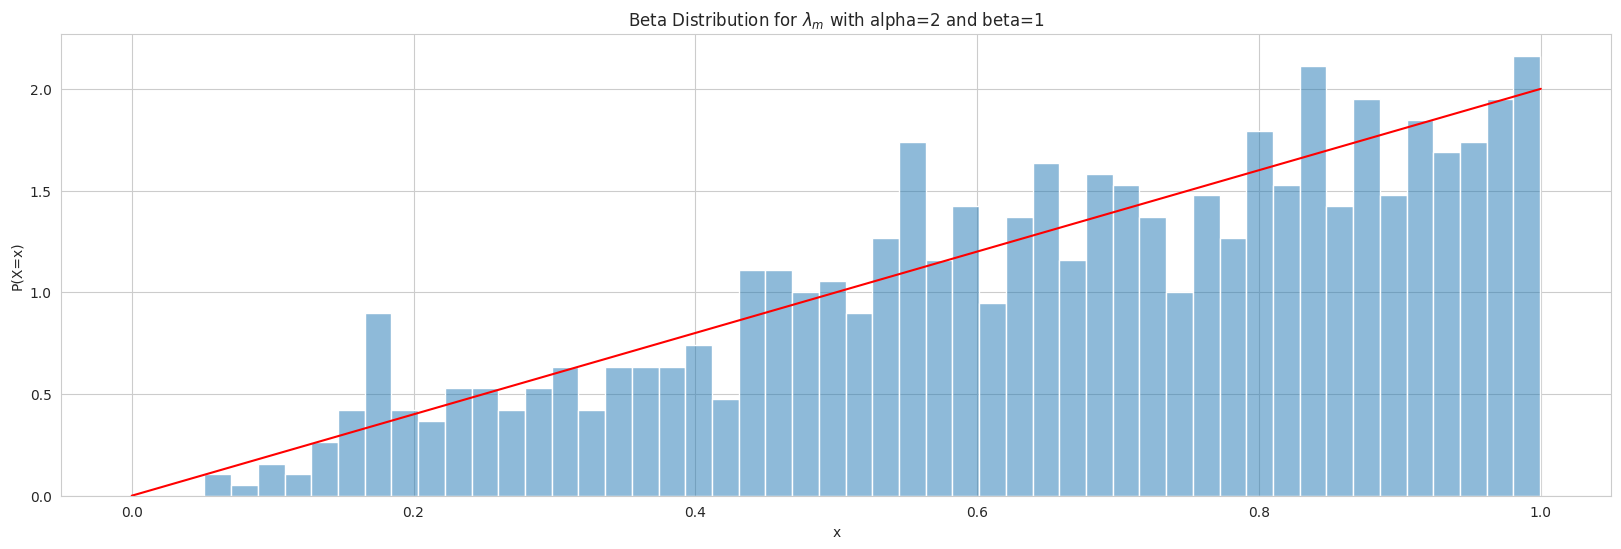

In [30]:
alpha = 2
beta = 1
draw_beta_distribution(alpha, beta, title = f"Beta Distribution for $\lambda_m$ with alpha={alpha} and beta={beta}")

In [48]:
#change priors for adstock decay
alpha = np.array([2.0] * len(media_channels))
beta = np.ones(len(media_channels))*4.0

#Beta(3,3) according to Bayesian Methods for Media Mix Modeling with Carryover and Shape Effects
#https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/46001.pdf
alpha[0] = 3.0
beta[0] = 3.0

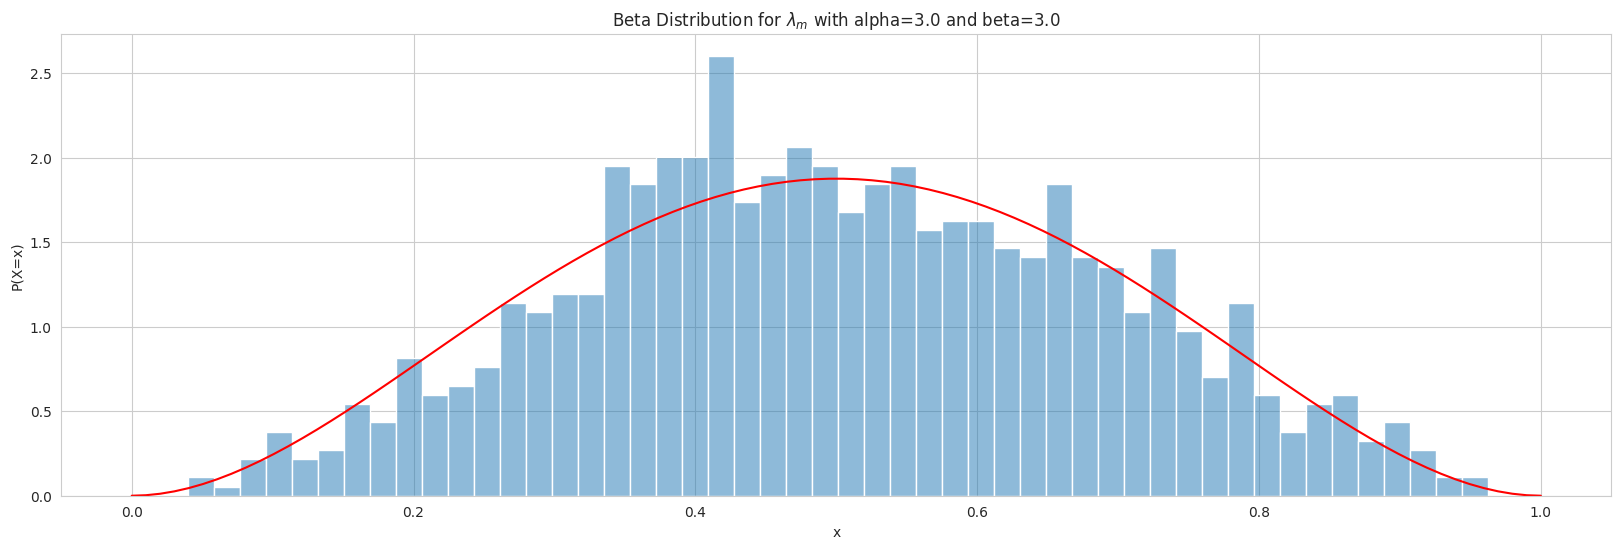

In [49]:
draw_beta_distribution(alpha = alpha[0], beta = beta[0], title = f"Beta Distribution for $\lambda_m$ with alpha={alpha[0]} and beta={beta[0]}")

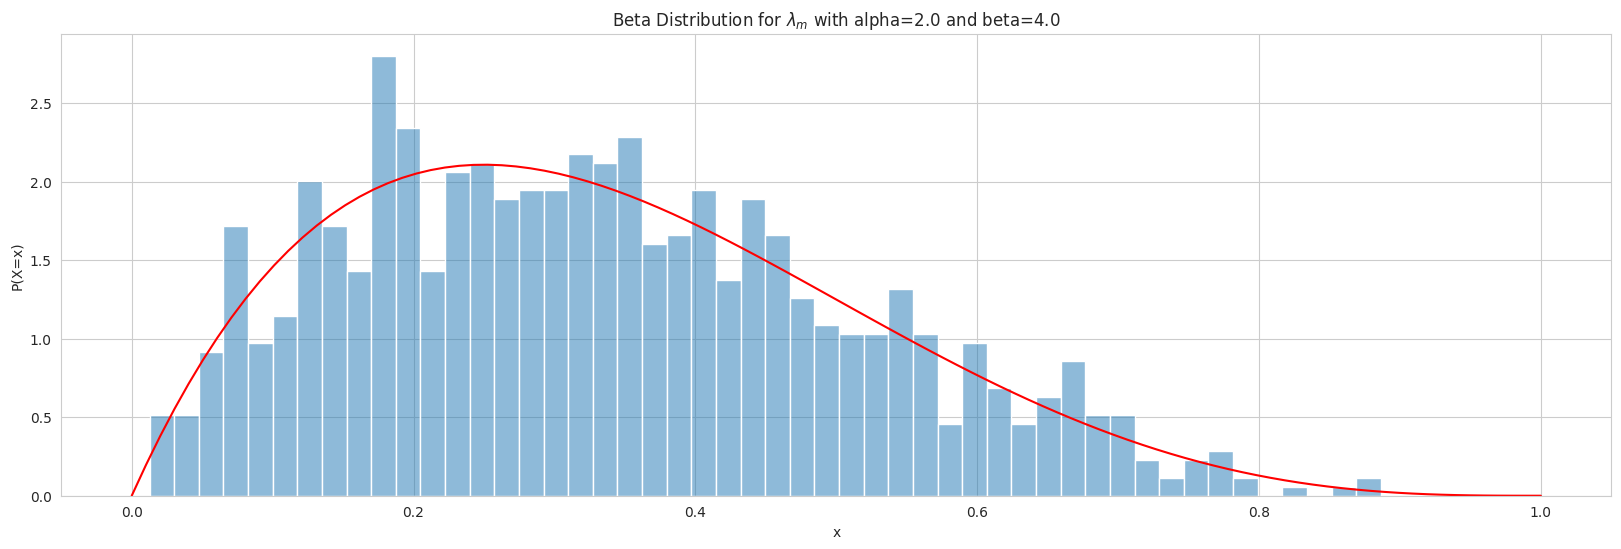

In [33]:
draw_beta_distribution(alpha = alpha[1], beta = beta[1], title = f"Beta Distribution for $\lambda_m$ with alpha={alpha[1]} and beta={beta[1]}")

In [34]:
lambdas = stats.beta(a=2, b=1).rvs(size = len(media_channels))
half_saturations = stats.gamma(a=1, scale=1).rvs(size = len(media_channels))
slopes = stats.gamma(a=1, scale=1).rvs(size = len(media_channels))

print(f"lambdas: {lambdas}")
print(f"half_saturations: {half_saturations}")
print(f"slopes: {slopes}")

lambdas: [           0.726            0.657            0.845            0.714            0.457]
half_saturations: [           2.380            0.534            0.338            1.638            0.181]
slopes: [           0.416            0.150            1.913            2.841            0.056]


In [35]:
media_data_transformation = np.asarray(media_data_scaled).copy()

In [36]:
for index, media_channel in enumerate(media_channels):
    lambda_ = lambdas[index]
    half_saturation = half_saturations[index]    
    slope = slopes[index]
    media_ = media_data_transformation[:, index]
    adstock_ = AdstockGeometric(lambda_).fit_transform(media_)
    hill_ = HillSaturation(slope_s=slope, half_saturation_k=half_saturation).fit_transform(adstock_)
    media_data_transformation[:, index] = hill_
    

In [37]:
components["media_channels"] = media_data_transformation @ media_coefficients

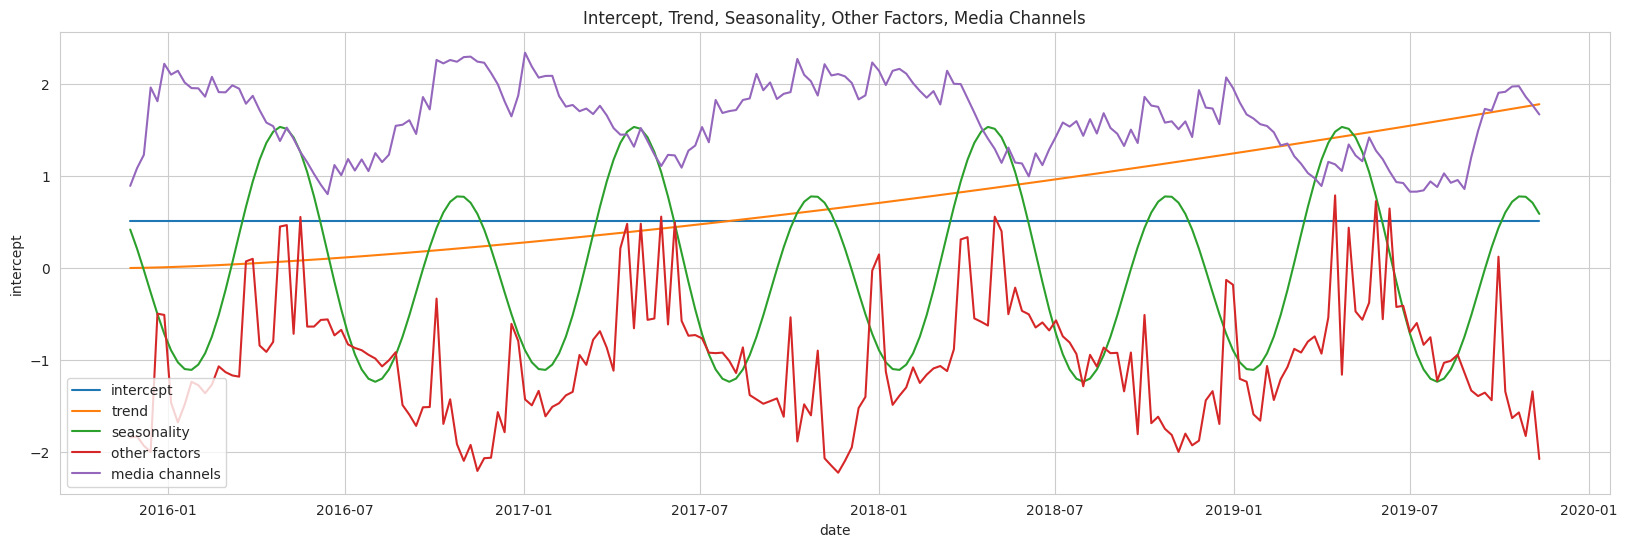

In [38]:
sns.set_style('whitegrid')
plt.figure(figsize=(20, 6))
sns.lineplot(x='date', y='intercept', data=components, label="intercept")
sns.lineplot(x='date', y='trend', data=components, label="trend")
sns.lineplot(x='date', y='seasonality', data=components, label="seasonality")
sns.lineplot(x='date', y='other_factors', data=components, label="other factors")
sns.lineplot(x='date', y='media_channels', data=components, label="media channels")
plt.title('Intercept, Trend, Seasonality, Other Factors, Media Channels')
plt.legend()
plt.show()

In [39]:
components["kpi"] = components["intercept"] + components["trend"] + components["seasonality"] + components["other_factors"] + components["media_channels"]

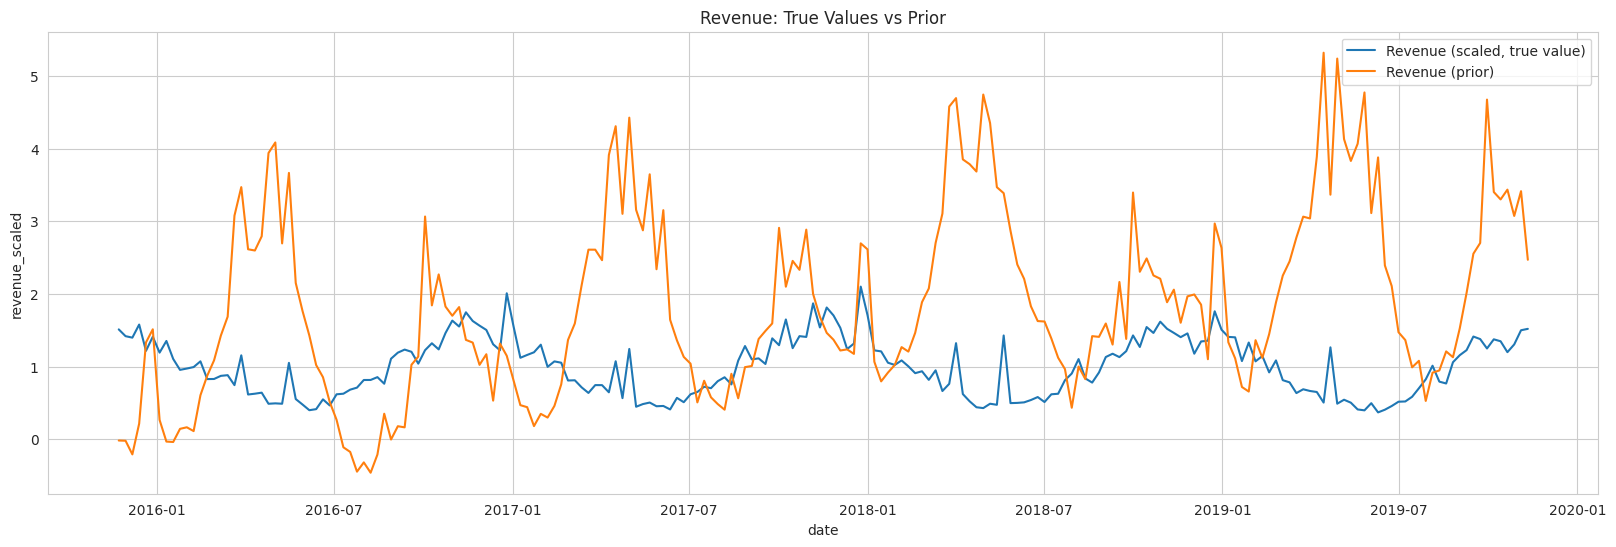

In [46]:
sns.set_style('whitegrid')
plt.figure(figsize=(20, 6))
sns.lineplot(x='date', y='revenue_scaled', data=components, label="Revenue (scaled, true value)")
sns.lineplot(x='date', y='kpi', data=components, label="Revenue (prior)")
plt.title('Revenue: True Values vs Prior')
plt.legend()
plt.show()

### Draw samples many times

In [41]:
def prior_sampling(data, media_channels):
    components = pd.DataFrame()
    components["date"] = data["date"]
    components["t_scaled"] = scikit_preprocessing.MinMaxScaler().fit_transform(np.array(range(0, len(data["date"]))).astype(float).reshape(-1, 1)).reshape(-1)
    #intercept
    
    components["intercept"] = stats.halfnorm(scale=scale).rvs()
    #trend
    mu = np.random.normal(loc = 0, scale = 1, size=1)
    k = np.random.uniform(low = 0.5, high = 1.5)
    trend = mu * components["t_scaled"] ** k
    components["trend"] = trend
    #seasonality
    gammas = np.random.normal(loc = 0, scale = 1, size=n_components * 2)
    seasonality = generate_seasonality(components["date"], period=52, n_components=2, gammas = gammas)
    components["seasonality"] = seasonality
    #other factors (continuous)
    other_factors_continuous_lambdas = np.random.normal(loc = 0, scale = 1, size=continuous_data_scaled.shape[1])
    other_factors_continuous = continuous_data_scaled @ other_factors_continuous_lambdas
    components["other_factors_continuous"] = np.asarray(other_factors_continuous)
    #other factors (factorized)
    other_factors_factorized_lambdas = np.random.normal(loc = 0, scale = 1, size=factorized_data_scaled.shape[1])
    other_factors_factorized = factorized_data_scaled @ other_factors_factorized_lambdas
    components["other_factors_factorized"] = np.asarray(other_factors_factorized)
    #other factors
    components["other_factors"] = components["other_factors_continuous"] + components["other_factors_factorized"]
    
    #media coefficients
    media_coefficients = stats.halfnorm(scale=costs_scaled).rvs()
    #media channels
    media_data_transformation = np.asarray(media_data_scaled).copy()
    lambdas = stats.beta(a=2, b=1).rvs(size = len(media_channels))
    half_saturations = stats.gamma(a=1, scale=1).rvs(size = len(media_channels))
    slopes = stats.gamma(a=1, scale=1).rvs(size = len(media_channels))
    for index, media_channel in enumerate(media_channels):
        lambda_ = lambdas[index]
        half_saturation = half_saturations[index]    
        slope = slopes[index]
        media_ = media_data_transformation[:, index]
        adstock_ = AdstockGeometric(lambda_).fit_transform(media_)
        hill_ = HillSaturation(slope_s=slope, half_saturation_k=half_saturation).fit_transform(adstock_)
        
        media_data_transformation[:, index] = hill_
        
    components["media_channels"] = media_data_transformation @ media_coefficients
    components["kpi"] = components["intercept"] + components["trend"] + components["seasonality"] + components["other_factors"] + components["media_channels"]
    
    return components["kpi"].values

In [42]:
runs = 5000
samples = np.zeros(shape = (data.shape[0], runs))
for run in range(runs):
    samples[:, run] = prior_sampling(data, media_channels)
    

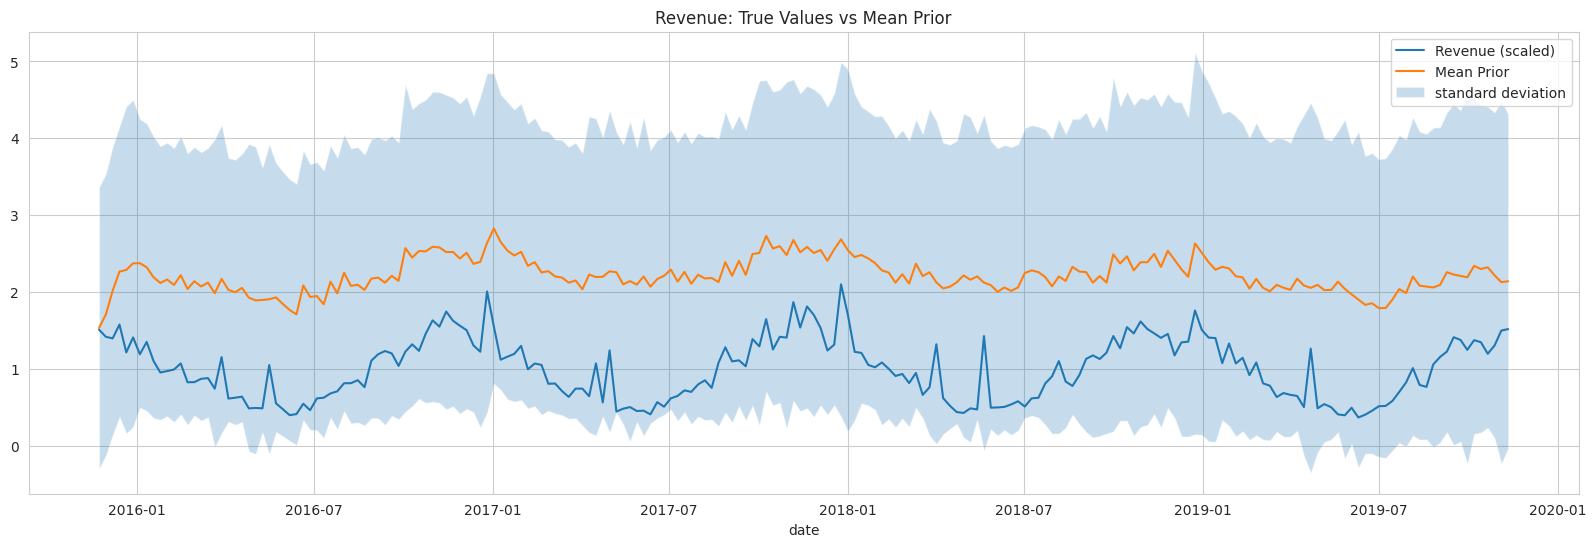

In [47]:
sns.set_style('whitegrid')
plt.figure(figsize=(20, 6))
sns.lineplot(x=data['date'], y=target_scaled, label="Revenue (scaled)")
sns.lineplot(x=data['date'], y=samples.mean(axis=1), label="Mean Prior")
plt.fill_between(x=data["date"], y1 = -samples.std(axis=1) + samples.mean(axis=1), y2= samples.std(axis=1) + samples.mean(axis=1), alpha=0.25, label='standard deviation')
plt.title('Revenue: True Values vs Mean Prior')
plt.legend()

plt.show()